In [1]:
import numpy as np
import os
import pandas as pd
import urllib
from sodapy import Socrata
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

## Set defaults for plots

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

sns.set_style("whitegrid", rc={"figure.figsize": (16, 8)})
sns.set_palette("colorblind")

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGE_FLDR = "eda"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", IMAGE_FLDR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Import and clean the data

In [3]:
#open the locally saved csv (includes data up to 4/30/2018)
df = pd.read_csv('data/mgm.csv', index_col=0)

In [4]:
#create a function to clean up the data
def cleanup(dataframe=df):
    """This function converts columns to appropriate dtypes and resets the index."""
    
    cat_cols = pd.Index(['jobtype', 'licensefeetype', 'permitstatus', 'subdiv', 'usetype', 'zoning', 'permittypecode'])
    dataframe[cat_cols] = dataframe[cat_cols].apply(pd.Categorical)
    
    num_cols = pd.Index(['estimatedcost', 'totalfee'])
    dataframe[num_cols] = dataframe[num_cols].apply(pd.to_numeric, errors='coerce')
    
    dataframe['physical_location_zip'] = dataframe['physical_location_zip'].fillna(0).astype(np.int64)
    
    dataframe['issueddate'] = pd.DatetimeIndex(dataframe['issueddate'])

    dataframe['estimatedcost'] = dataframe['estimatedcost'].fillna(0) #replace null values with 0s
    dataframe['totalfee'] = dataframe['totalfee'].fillna(0) #replace null values with 0s
    
    dataframe['parcelno_clean'] = dataframe.parcelno.str.replace(" ", "").str.replace(".", "") #create a new columns with no spaces or periods in parcelno
    dataframe['parcelno_clean'] = dataframe['parcelno_clean'].fillna(0).astype(np.int64)
    
    drop_cols = ['contractors_location_address', 'issueddate',
       'contractors_location_city', 'contractors_location_state',
       'contractors_location_zip', 'contractorsaddress', 'contractorscity',
       'contractorsemail', 'contractorsphone',
       'contractorsstate', 'contractorszip', 'month', 'owndersaddress',
       'ownderszip', 'owners_location_address',
       'owners_location_city', 'owners_location_state', 'owners_location_zip',
       'ownerscity', 'ownersstate', 'permitstatus',
       'physicaladdress', 'physicalcity',
       'physicalstate', 'physicalzip', 'year']
    dataframe.drop(columns=drop_cols, inplace=True)
    
    dataframe = dataframe.reset_index()

cleanup()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17514 entries, 14316 to 17668
Data columns (total 24 columns):
contractors_location         11793 non-null object
contractorsname              17514 non-null object
description                  17514 non-null object
estimatedcost                17514 non-null float64
jobtype                      17514 non-null category
licensefeetype               16125 non-null category
owners_location              14012 non-null object
ownersname                   17489 non-null object
parcelno                     17445 non-null object
permitno                     17514 non-null object
permittypecode               17514 non-null category
permittypedescription        17514 non-null object
physical_location            16226 non-null object
latitude                     16226 non-null float64
longitude                    16226 non-null float64
physical_location_address    17514 non-null object
physical_location_city       17511 non-null object
physical_lo

In [6]:
#list for project_proposal formatted for markdown
for col, typ in df.dtypes.items():
    print("|",col,"|",typ,"|")

| contractors_location | object |
| contractorsname | object |
| description | object |
| estimatedcost | float64 |
| jobtype | category |
| licensefeetype | category |
| owners_location | object |
| ownersname | object |
| parcelno | object |
| permitno | object |
| permittypecode | category |
| permittypedescription | object |
| physical_location | object |
| latitude | float64 |
| longitude | float64 |
| physical_location_address | object |
| physical_location_city | object |
| physical_location_state | object |
| physical_location_zip | int64 |
| subdiv | category |
| totalfee | float64 |
| usetype | category |
| zoning | category |
| parcelno_clean | int64 |


In [7]:
#column name and the first few items for reporting purposes
for i in range(0,len(df.columns)):
    col = []
    col = df.columns[i]
    print(df.columns[i], list(df[col].value_counts().index)[:6])

contractors_location ["{'type': 'Point', 'coordinates': [-86.187505, 32.312643]}", "{'type': 'Point', 'coordinates': [-86.788261, 33.360016]}", "{'type': 'Point', 'coordinates': [-84.250983, 33.898235]}", "{'type': 'Point', 'coordinates': [-86.290842, 32.375173]}", "{'type': 'Point', 'coordinates': [-85.375869, 32.645099]}", "{'type': 'Point', 'coordinates': [-86.299651, 32.376547]}"]
contractorsname ['LOWDER NEW HOMES', 'CERT OF OCCUPANCY', 'WINDOWS USA', 'THD @ HOME SERVICES', 'D R HORTON', 'STONE MARTIN BUILDERS LLC']
description ['REPLACE WINDOWS TO EXISTING SINGLE FAMILY DWELLING. BEDROOM WINDOWS PER CODES. TO MEET ALL APPLICABLE CODES.', 'GENERAL REPAIRS TO EXISTING SINGLE FAMILY DWELLING TO REPLACE WINDOWS TO EXISTING SINGLE FAMILY DWELLING. BEDROOM WINDOWS PER CODES. MUST COMPLY WITH STATE ENERGY CODE. TO MEET ALL APPLICABLE CODES.', 'GENERAL REPAIRS TO REPLACE WINDOWS TO EXISTING DWELLING. BEDROOM WINDOWS PER CODES. TO MEET ALL APPLICABLE CODES.', 'GENERAL REPAIRS TO EXISTING 

## Exploratory Data Analysis

Saving figure use_type_counts


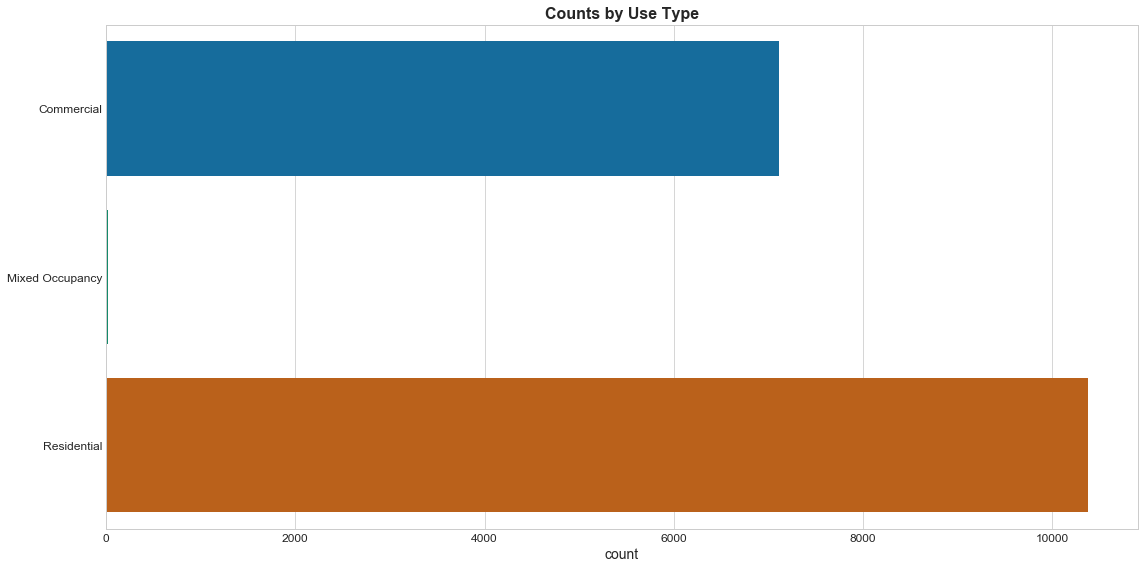

In [8]:
fig, ax = plt.subplots()
g = sns.countplot(data=df, y='usetype')
g = ax.set_title('Counts by Use Type')
g = ax.set_ylabel("")
save_fig("use_type_counts")

In [9]:
#There are very few "Mixed Occupancy" records in the usetype column
len(df[df.usetype == "Mixed Occupancy"])

20

Saving figure job_type_counts


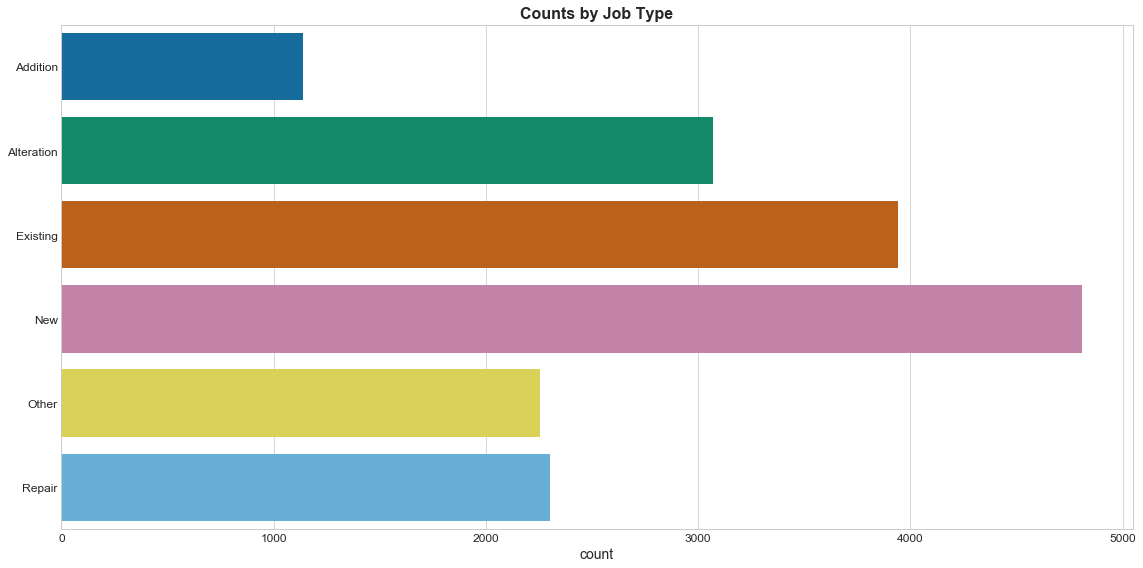

In [10]:
fig, ax = plt.subplots()
g = sns.countplot(data=df, y='jobtype')
g = ax.set_title('Counts by Job Type')
g = ax.set_ylabel("")
save_fig("job_type_counts")

Saving figure use_&_job_type_counts


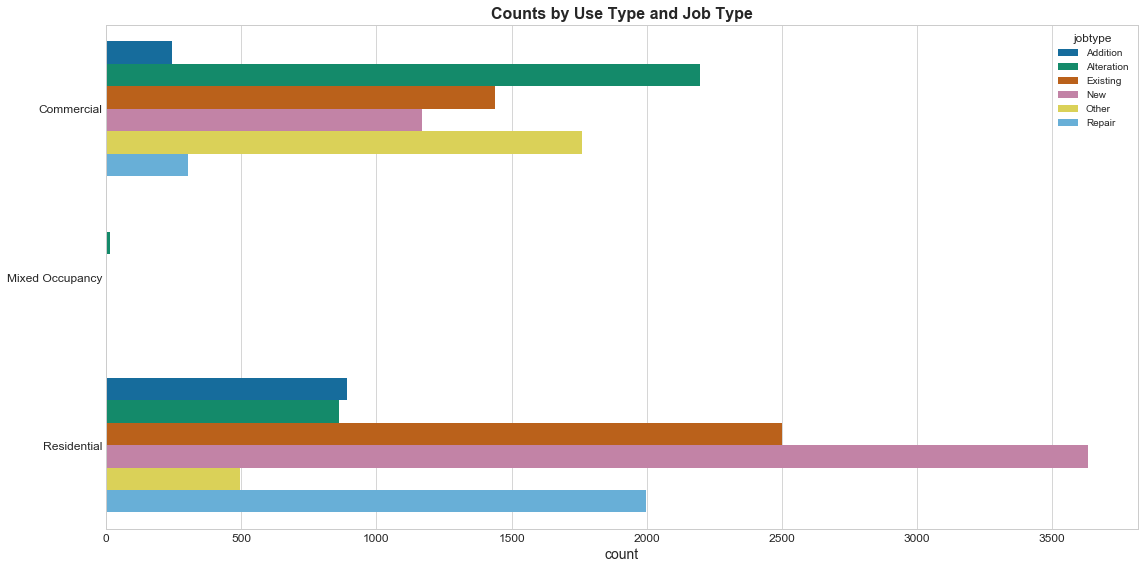

In [11]:
fig, ax = plt.subplots()
g = sns.countplot(data=df, y='usetype', hue='jobtype')
g = ax.set_title('Counts by Use Type and Job Type')
g = ax.set_ylabel("")
save_fig("use_&_job_type_counts")

Saving figure usetype_estimatedcost_licensefeetype_counts


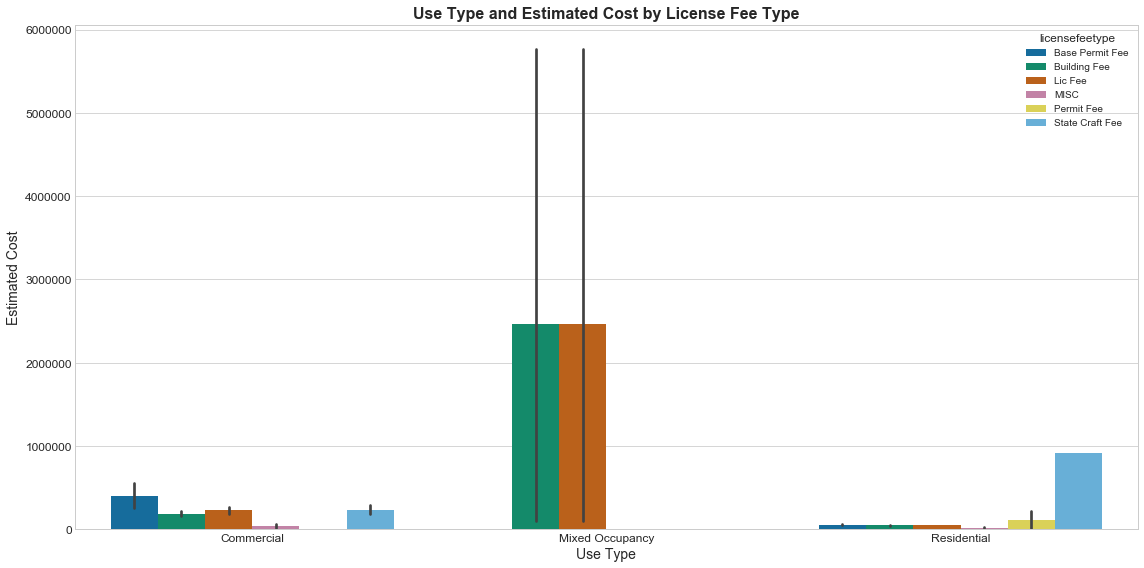

In [12]:
fig, ax = plt.subplots()
g = sns.barplot(data=df, x='usetype', y='estimatedcost', hue='licensefeetype')
g = ax.set_title('Use Type and Estimated Cost by License Fee Type')
g = ax.set_xlabel("Use Type")
g = ax.set_ylabel("Estimated Cost")
save_fig("usetype_estimatedcost_licensefeetype_counts")

Saving figure estimated_cost_mixedocc_dist


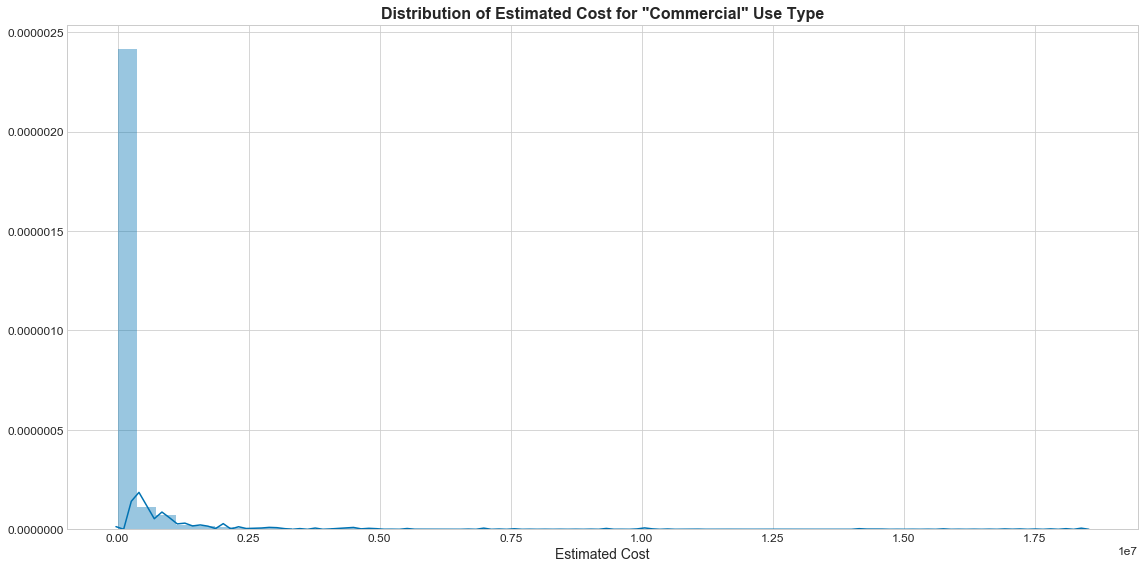

In [13]:
fig, ax = plt.subplots()
g = sns.distplot(df.estimatedcost[df.usetype=='Commercial'])
g = ax.set_title('Distribution of Estimated Cost for "Commercial" Use Type')
g = ax.set_xlabel("Estimated Cost")
g = ax.set_ylabel("")
save_fig("estimated_cost_mixedocc_dist")

Saving figure estimated_cost_mixedocc_dist


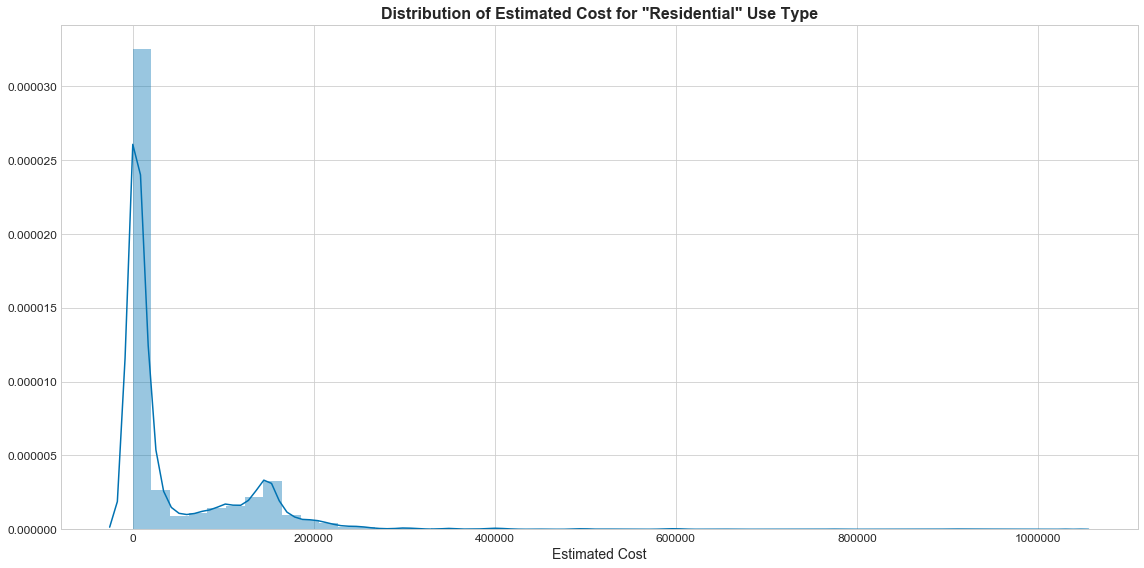

In [14]:
fig, ax = plt.subplots()
g = sns.distplot(df.estimatedcost[df.usetype=='Residential'])
g = ax.set_title('Distribution of Estimated Cost for "Residential" Use Type')
g = ax.set_xlabel("Estimated Cost")
g = ax.set_ylabel("")
save_fig("estimated_cost_mixedocc_dist")

Saving figure estimated_cost_mixedocc_dist


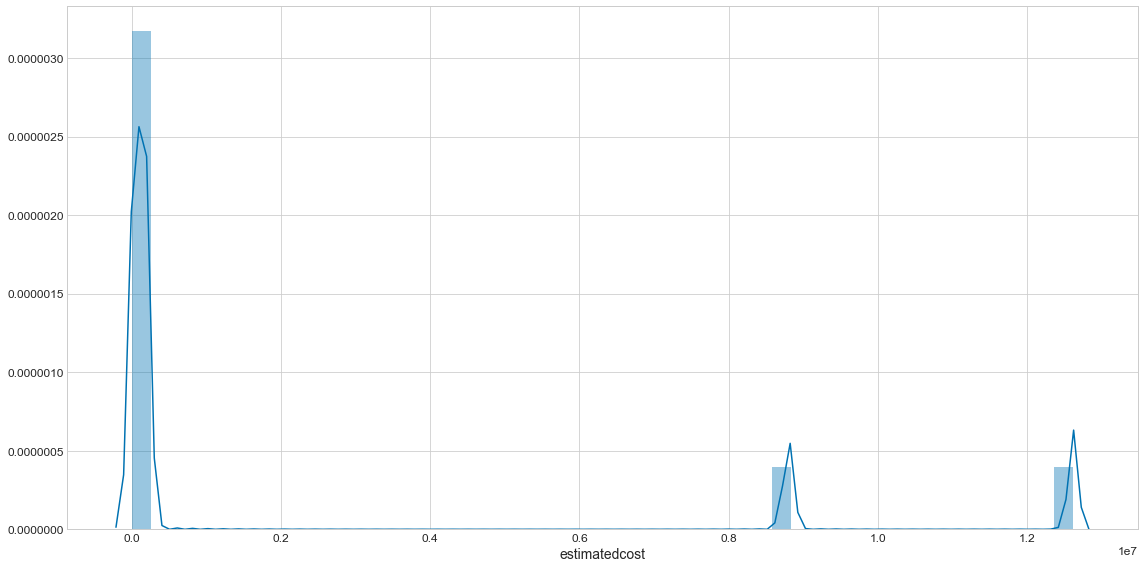

In [15]:
g = sns.distplot(df.estimatedcost[df.usetype=='Mixed Occupancy'])
g = ax.set_title('Distribution of Estimated Cost for "Mixed Occupancy" Use Type')
g = ax.set_xlabel("Estimated Cost")
g = ax.set_ylabel("")
save_fig("estimated_cost_mixedocc_dist")

C:\Users\595217\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


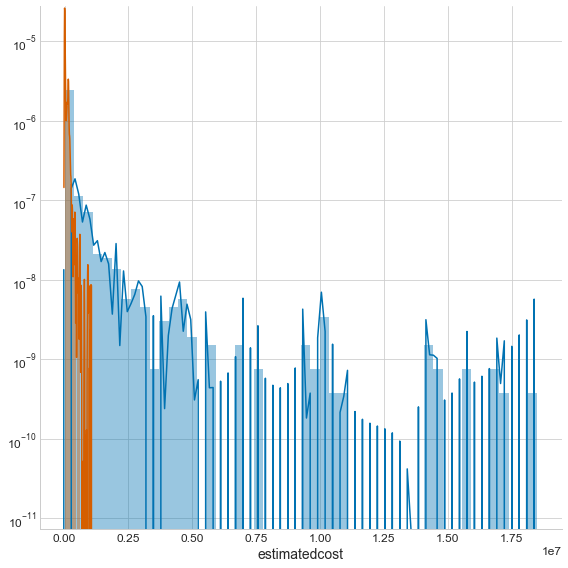

In [16]:
g = sns.FacetGrid(df[df.usetype!='Mixed Occupancy'], hue="usetype", size=8)
g = g.map(sns.distplot, "estimatedcost", hist_kws={'log':True})
g = fig.set_size_inches(10,10)

Saving figure licensefeetype_counts


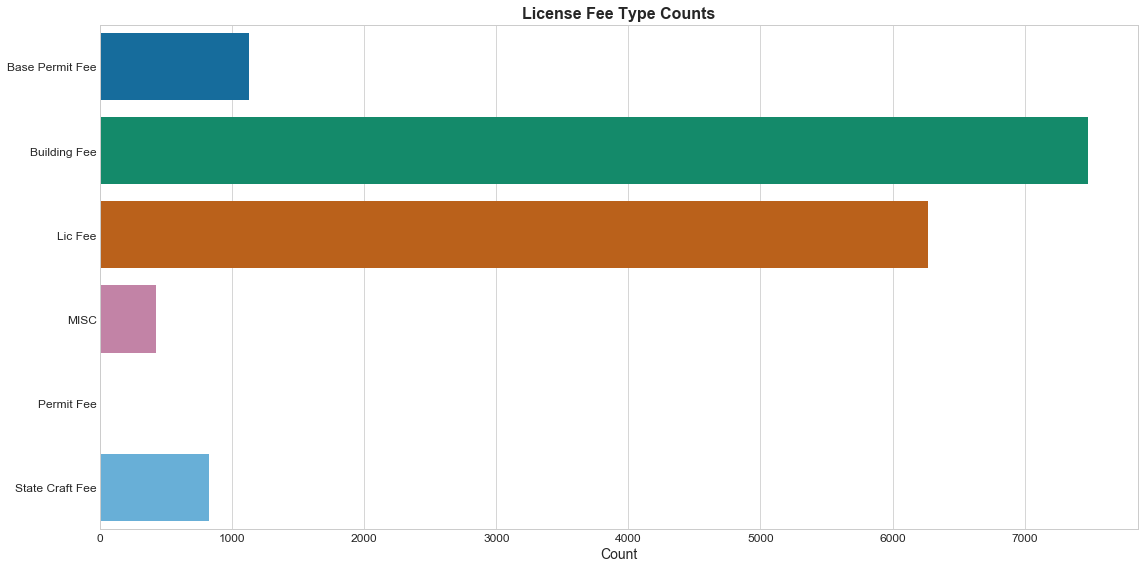

In [17]:
fig, ax = plt.subplots()
g = sns.countplot(data=df, y='licensefeetype')
g = ax.set_title('License Fee Type Counts')
g = ax.set_xlabel("Count")
g = ax.set_ylabel("")
save_fig("licensefeetype_counts")

Saving figure permittypecode_counts


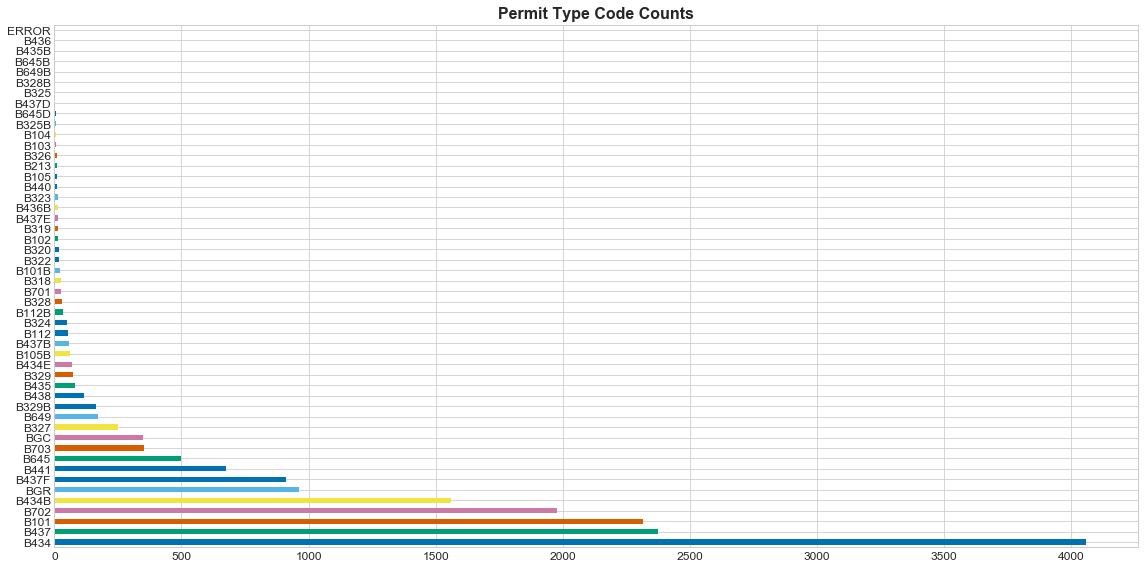

In [18]:
df.permittypecode.value_counts().plot(kind='barh')
plt.title('Permit Type Code Counts')
save_fig("permittypecode_counts")

Saving figure permittypecode_counts_top10


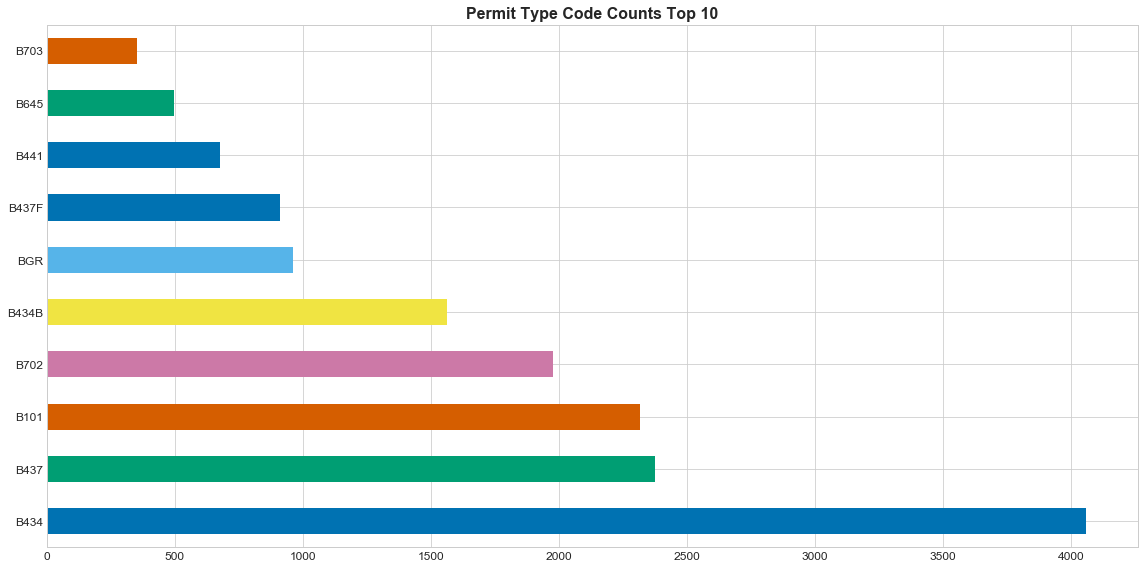

In [19]:
df.permittypecode.value_counts().head(10).plot(kind='barh')
plt.title('Permit Type Code Counts Top 10')
save_fig("permittypecode_counts_top10")

Saving figure zoningcode_counts_top10


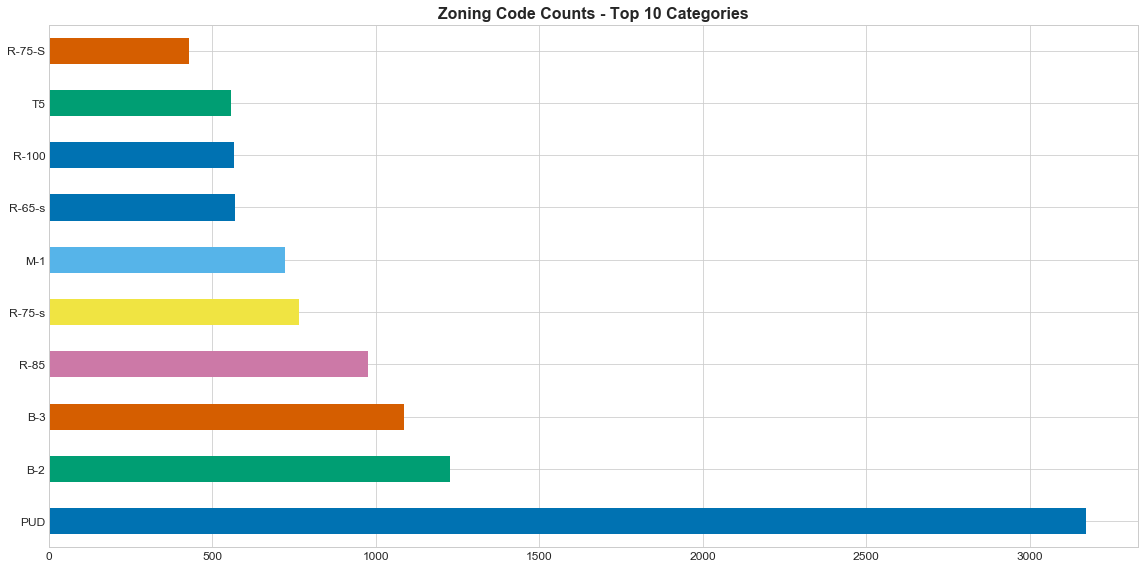

In [20]:
df.zoning.value_counts().head(10).plot(kind='barh')
plt.title('Zoning Code Counts - Top 10 Categories')
save_fig("zoningcode_counts_top10")

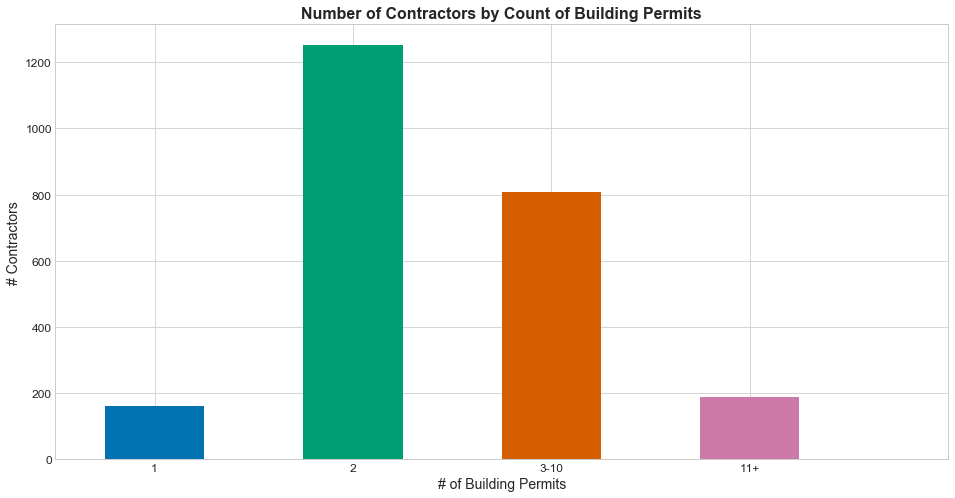

In [21]:
df.contractorsname.value_counts().sort_index().reset_index()['contractorsname'].value_counts(bins=[0,1,2,10,9999999999]).sort_index().plot(kind='bar')
plt.xticks((0,1,2,3,4), ['1','2','3-10','11+'], rotation='horizontal')
plt.title("Number of Contractors by Count of Building Permits")
plt.tick_params()
plt.ylabel("# Contractors")
plt.xlabel('# of Building Permits');

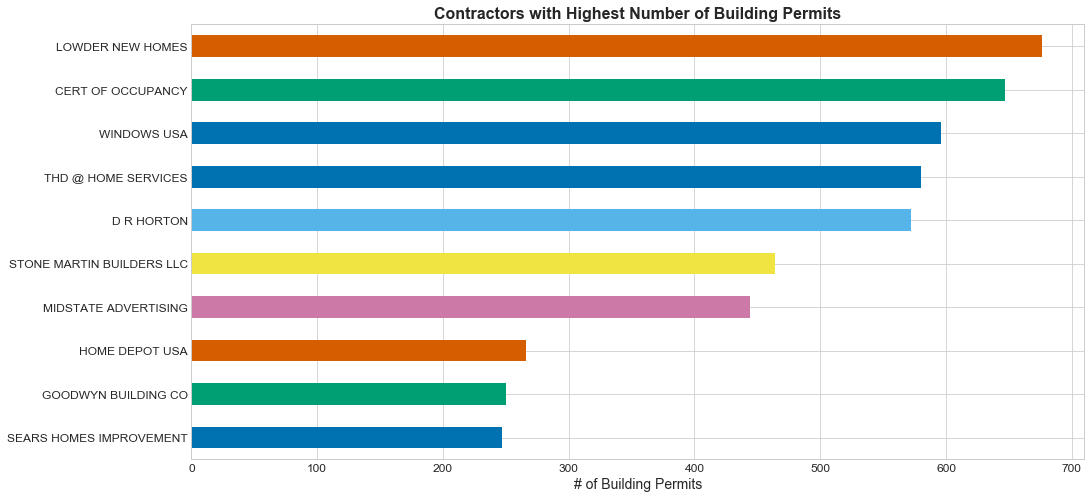

In [22]:
df.contractorsname.value_counts().head(10).sort_values().plot(kind='barh')
plt.title('Contractors with Highest Number of Building Permits')
plt.xlabel('# of Building Permits');

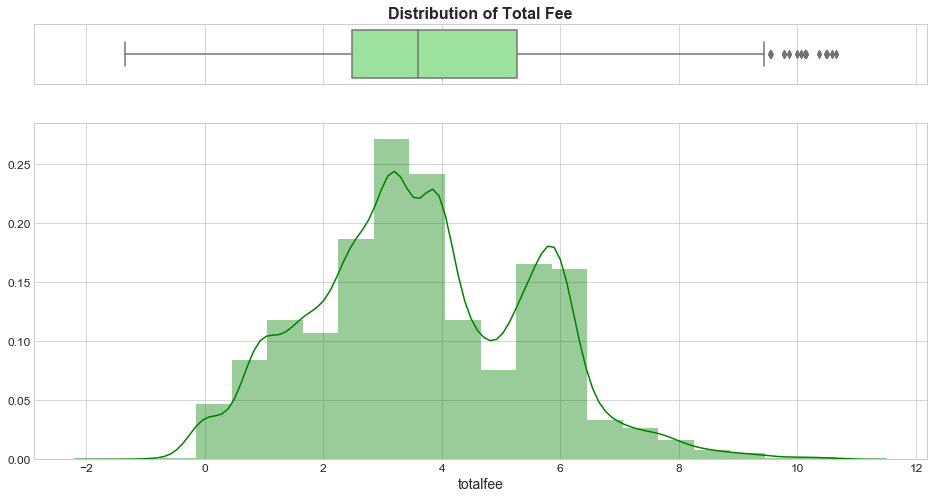

In [23]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(np.log(df.totalfee[df.totalfee != 0]), ax=ax_box, color='lightgreen')
sns.distplot(np.log(df.totalfee[df.totalfee != 0]), bins=20, ax=ax_hist, color='green')
ax_box.set(xlabel='', title='Distribution of Total Fee');

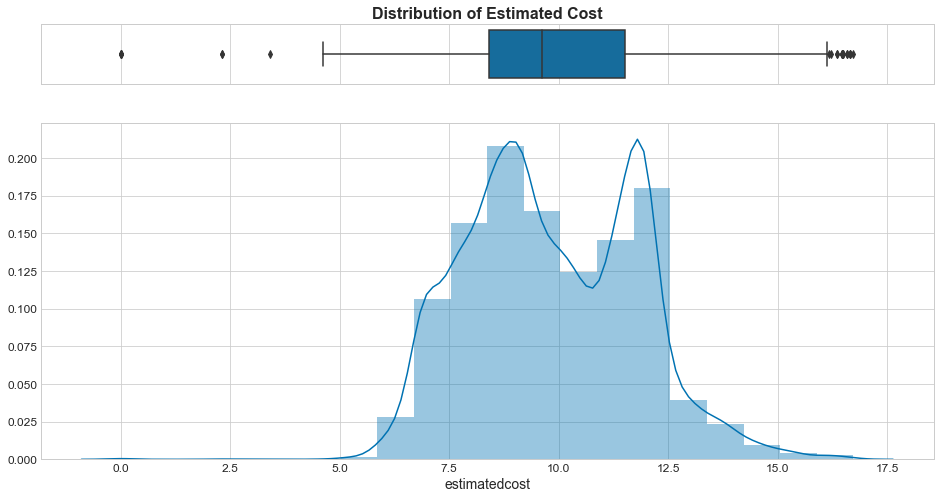

In [24]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
g = sns.boxplot(np.log(df.estimatedcost[df.estimatedcost != 0]), ax=ax_box) 
g = sns.distplot(np.log(df.estimatedcost[df.estimatedcost != 0]), bins=20, ax=ax_hist)
ax_box.set(xlabel='', title='Distribution of Estimated Cost');

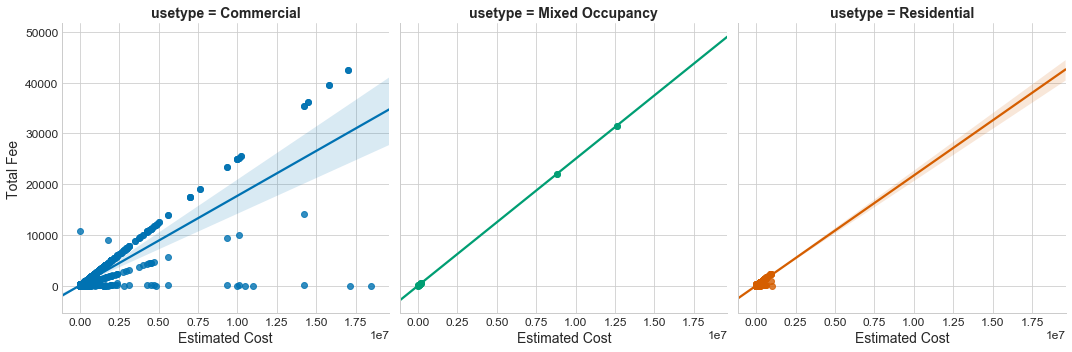

In [25]:
g = sns.lmplot(data=df, x='estimatedcost', y='totalfee', hue='usetype', col='usetype')
g = g.set_axis_labels("Estimated Cost", "Total Fee");

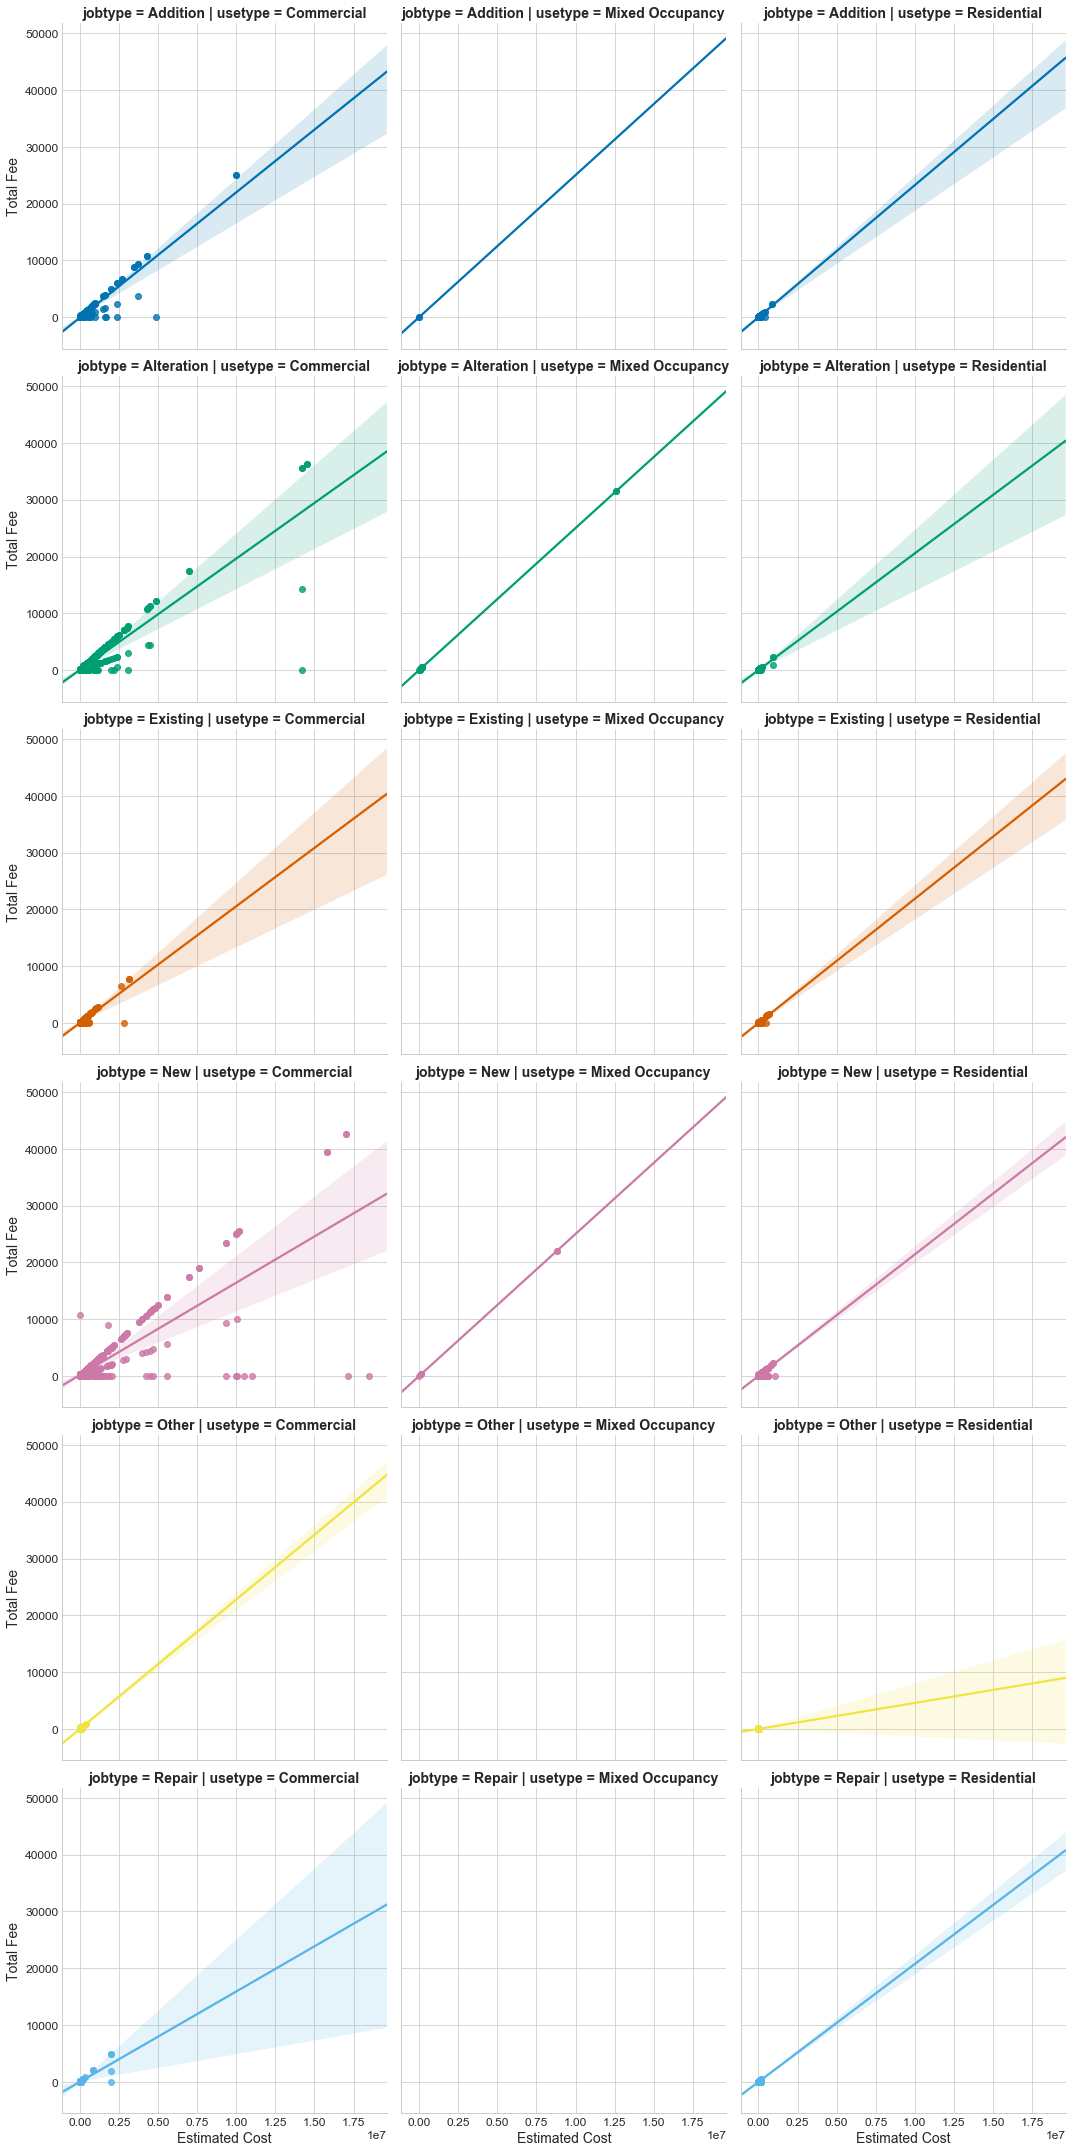

In [26]:
g = sns.lmplot(data=df, x='estimatedcost', y='totalfee', hue='jobtype', col='usetype', row='jobtype')
g = g.set_axis_labels("Estimated Cost", "Total Fee");

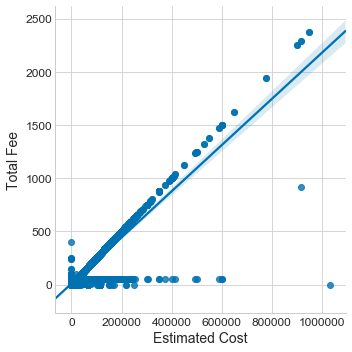

In [27]:
g = sns.lmplot(data=df[df.usetype=='Residential'], x='estimatedcost', y='totalfee')
g = g.set_axis_labels("Estimated Cost", "Total Fee");

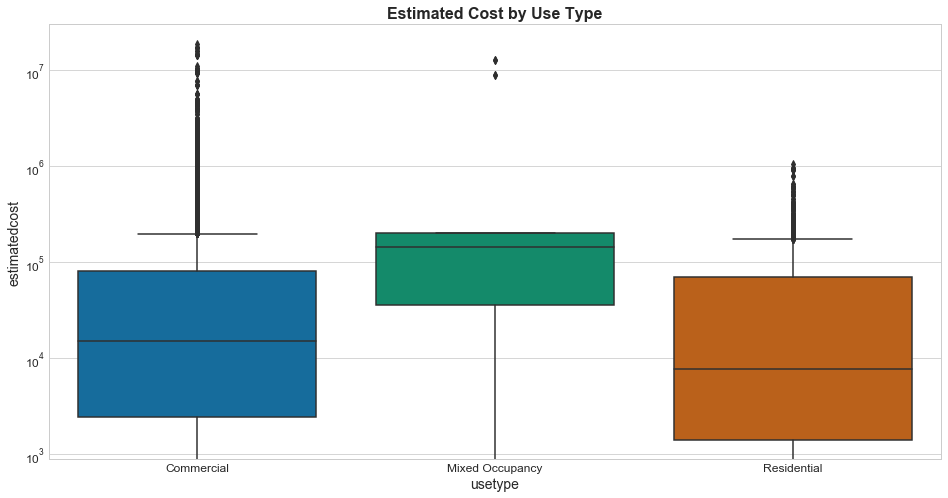

In [28]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='usetype', y='estimatedcost')
ax.set_yscale("log")
ax.set_title('Estimated Cost by Use Type');

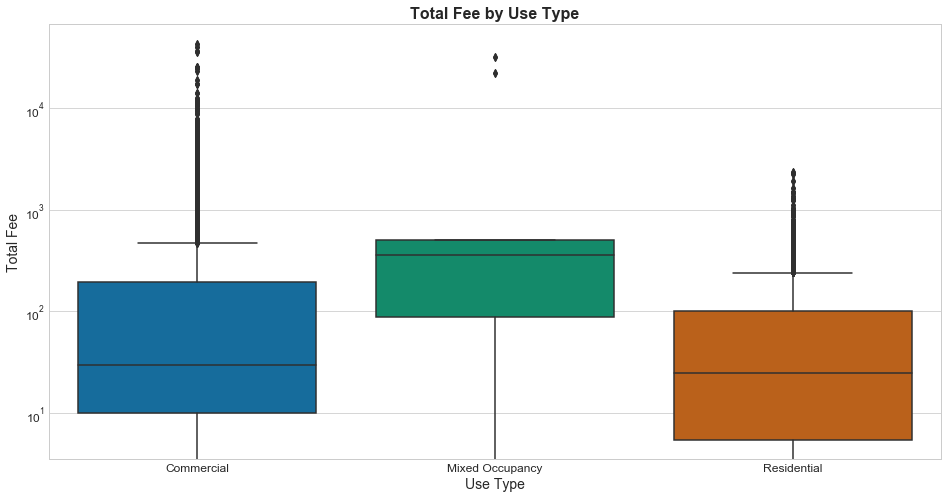

In [29]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='usetype', y='totalfee')
ax.set_yscale("log")
ax.set_title('Total Fee by Use Type')
ax.set_xlabel('Use Type')
ax.set_ylabel('Total Fee');

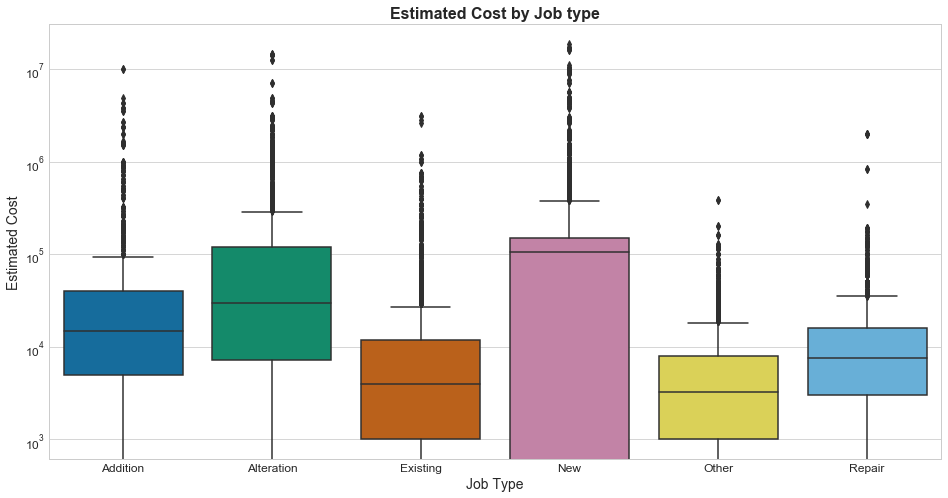

In [30]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='jobtype', y='estimatedcost')
ax.set_yscale("log")
ax.set_title('Estimated Cost by Job type')
ax.set_xlabel('Job Type')
ax.set_ylabel('Estimated Cost');

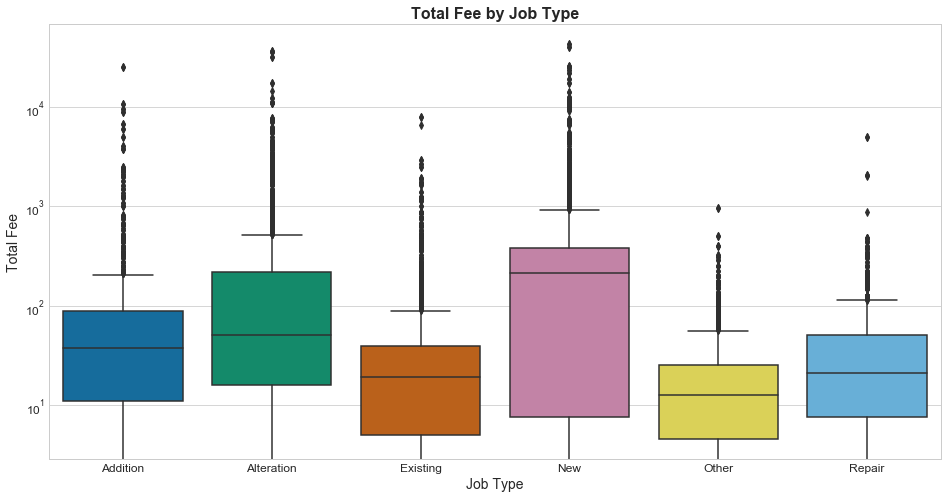

In [31]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='jobtype', y='totalfee')
ax.set_yscale("log")
ax.set_title('Total Fee by Job Type')
ax.set_xlabel('Job Type')
ax.set_ylabel('Total Fee');

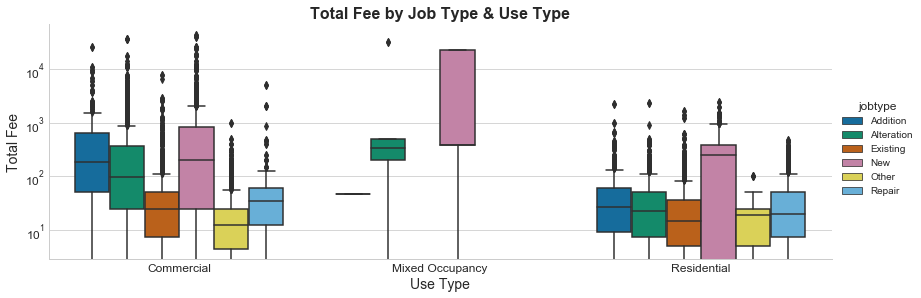

In [32]:
g = sns.factorplot(data=df, x='usetype', y='totalfee', hue='jobtype', kind='box', size=4, aspect=3)
g = g.set_axis_labels("Use Type", "Total Fee")
g = g.fig.get_axes()[0].set_yscale('log')
plt.title('Total Fee by Job Type & Use Type');

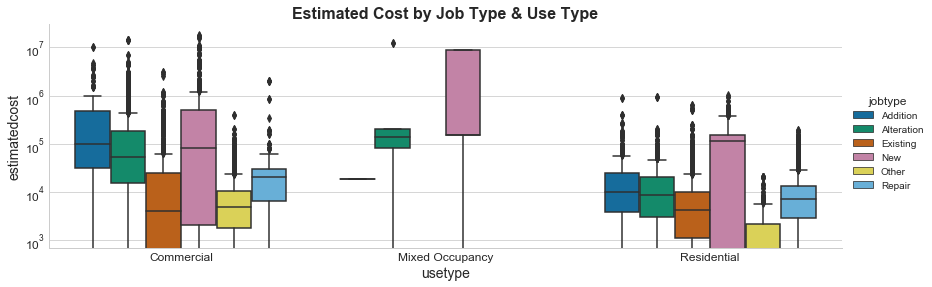

In [33]:
g= sns.factorplot(data=df, x='usetype', y='estimatedcost', hue='jobtype', kind='box', size=4, aspect=3)
g.fig.get_axes()[0].set_yscale('log')
plt.title('Estimated Cost by Job Type & Use Type');

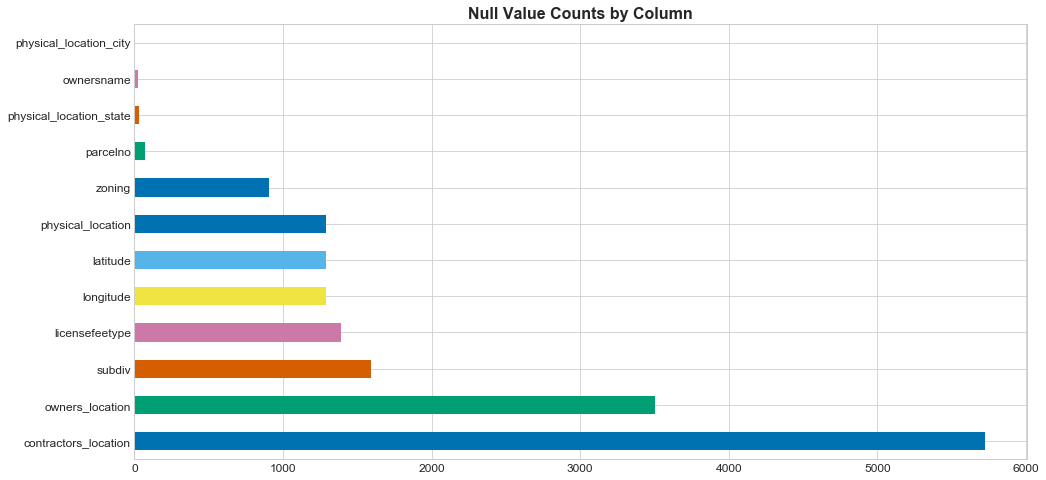

In [34]:
null_cols = df.isnull().sum() 
null_cols[null_cols!=0].sort_values(ascending=False).plot(kind='barh')
plt.title('Null Value Counts by Column');

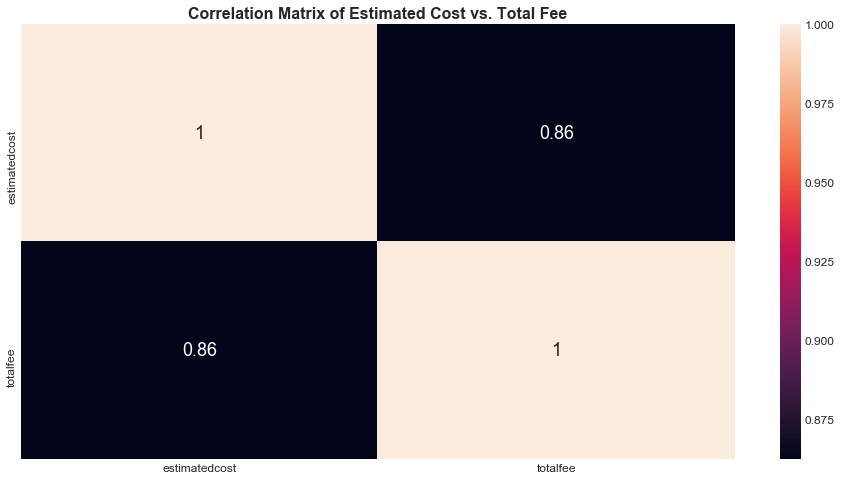

In [35]:
corr = df[['estimatedcost', 'totalfee']].corr()
g = sns.heatmap(corr, annot=True, annot_kws={"size": 18},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
plt.title('Correlation Matrix of Estimated Cost vs. Total Fee');